This notebook aims to implement methods (padding, windowing) to reduce artefacts in Fourier transforms of memory signals. It also explores the effects of these methods on the resulting frequency spectra. 

In [220]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from lal import MSUN_SI, MTSUN_SI, PC_SI, C_SI, G_SI
from pycbc.waveform import get_td_waveform, get_td_waveform_modes
from pycbc.filter import highpass, lowpass
from pycbc.types import TimeSeries
import gwmemory
from scipy.fft import fft, fftfreq
from tqdm import tqdm
from matplotlib.animation import PillowWriter
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline

In [221]:
# Compute the spin-weighted spherical harmonics
# Definition based on the article : https://arxiv.org/pdf/0812.0069#page=5.61
def fac(n): # Défini n! 
    if n==0 or n==1:
        return 1
    result = 1
    for i in range(2, n+1):
        result *= i
    return result

def dlms(l, m, s, Theta): # eq (2.14)
    
    sq = np.sqrt(fac(l+m)*fac(l-m)*fac(l+s)*fac(l-s))
    d = 0.
    for k in range(max(0,m-s),min(l+m,l-s)+1):
        d += (-1.)**k*np.sin(Theta/2.)**(2.*k+s-m)*np.cos(Theta/2.)**(2.*l+m-s-2.*k)/(fac(k)*fac(l+m-k)*fac(l-s-k)*fac(s-m+k))
    return sq*d

def sYlm(s,l,m,Theta,Phi): # eq (2.13)
    
    res = (-1.)**(-s)*np.sqrt((2.*l+1)/(4*np.pi))*dlms(l,m,-s,Theta)
    
    if res==0:
        return 0
    else:
        return complex(res*np.cos(m*Phi), res*np.sin(m*Phi)) # e^(imPhi)

In [222]:
# Compute the fft of a given signal
def fft_signal(time, signal):
    N = len(signal)
    T = time[1] - time[0]
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    return xf, 2.0/N * np.abs(yf[0:N//2])

In [223]:
from scipy.signal.windows import tukey, hann
from scipy.signal import butter, filtfilt
def align_signal(signal, time):
    """
    Align the signal so that the merger (maximum amplitude) is at t=0.
    Returns the aligned time and signal arrays.
    """
    amplitude = np.abs(signal)
    merger_idx = np.argmax(amplitude)
    merger_time = time[merger_idx]
    t_aligned = time - merger_time
    return t_aligned, signal

def normalize_signal(signal):
    """Normalize the signal to its maximum absolute value."""
    return signal / np.max(np.abs(signal))

def normalize_signal(signal):
    """Normalize the signal to its maximum absolute value."""
    max_val = np.max(np.abs(signal))
    if max_val == 0:
        return signal
    return signal / max_val

def apply_window(signal, window_type='tukey', r=0.5, alpha=0.2):
    """
    Apply a window of length n_window = r * len(signal) centered on the merger (max amplitude).
    """
    n_signal = len(signal)
    n_window = int(round(n_signal * r))
    if n_window < 1:
        return signal
    peak_index = np.argmax(np.abs(signal))
    pad_left = max(0, peak_index - n_window // 2)
    pad_right = n_signal - (pad_left + n_window)
    if pad_right < 0:
        pad_right = 0
        pad_left = n_signal - n_window
    if window_type == 'tukey':
        window = tukey(n_window, alpha)
    elif window_type == 'hann':
        window = hann(n_window)
    else:
        raise ValueError("Window type must be 'tukey' or 'hann'")
    window_full = np.pad(window, (pad_left, pad_right), 'constant', constant_values=(0, 0))
    return signal * window_full

def pad_signal(signal, time, seconds):
    """Pad the signal and time array with zeros to add a given number of seconds at the end (right side only)."""
    dt = time[1] - time[0]
    pad_size = int(np.round(seconds / dt))
    if pad_size > 0:
        signal_padded = np.pad(signal, (0, pad_size), 'constant')
        time_padded = np.concatenate([time, time[-1] + dt * np.arange(1, pad_size + 1)])
        return time_padded, signal_padded
    else:
        return time, signal

def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    """Filter the signal with a bandpass filter between lowcut and highcut frequencies."""
    nyq = 0.5 * fs
    low = max(lowcut / nyq, 1e-6)
    high = min(highcut / nyq, 1 - 1e-6)
    if low >= high:
        raise ValueError("lowcut must be less than highcut and both < Nyquist")
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [224]:
# Test the functions with a sample waveform
dt = 1.0/4096
distance = 100
hp, _ = get_td_waveform(approximant="SEOBNRv4_ROM_NRTidalv2",
                        mass1=50, mass2=50,
                        delta_t=dt,
                        f_lower=20,
                        distance=distance,
                        inclination=np.pi/2,
                        spin_1z=0.0, spin_2z=0.0, 
                        spin_1y=0.0, spin_2y=0.0,
                        spin_1x=0.0, spin_2x=0.0, 
                        phase = 0.0)

time_raw  = hp.sample_times.numpy()
raw_signal = hp.numpy()
fs = int(1.0 / hp.delta_t)
seconds = 0.2  # seconds to pad at the end

aligned_time, aligned_signal = align_signal(raw_signal, time_raw)

windowed_signal = apply_window(aligned_signal, window_type='tukey', r = 0.75, alpha=0.2)

padded_time, padded_signal = pad_signal(windowed_signal,aligned_time, seconds)

filtered_signal = bandpass_filter(padded_signal, fs, lowcut=10, highcut=1000)

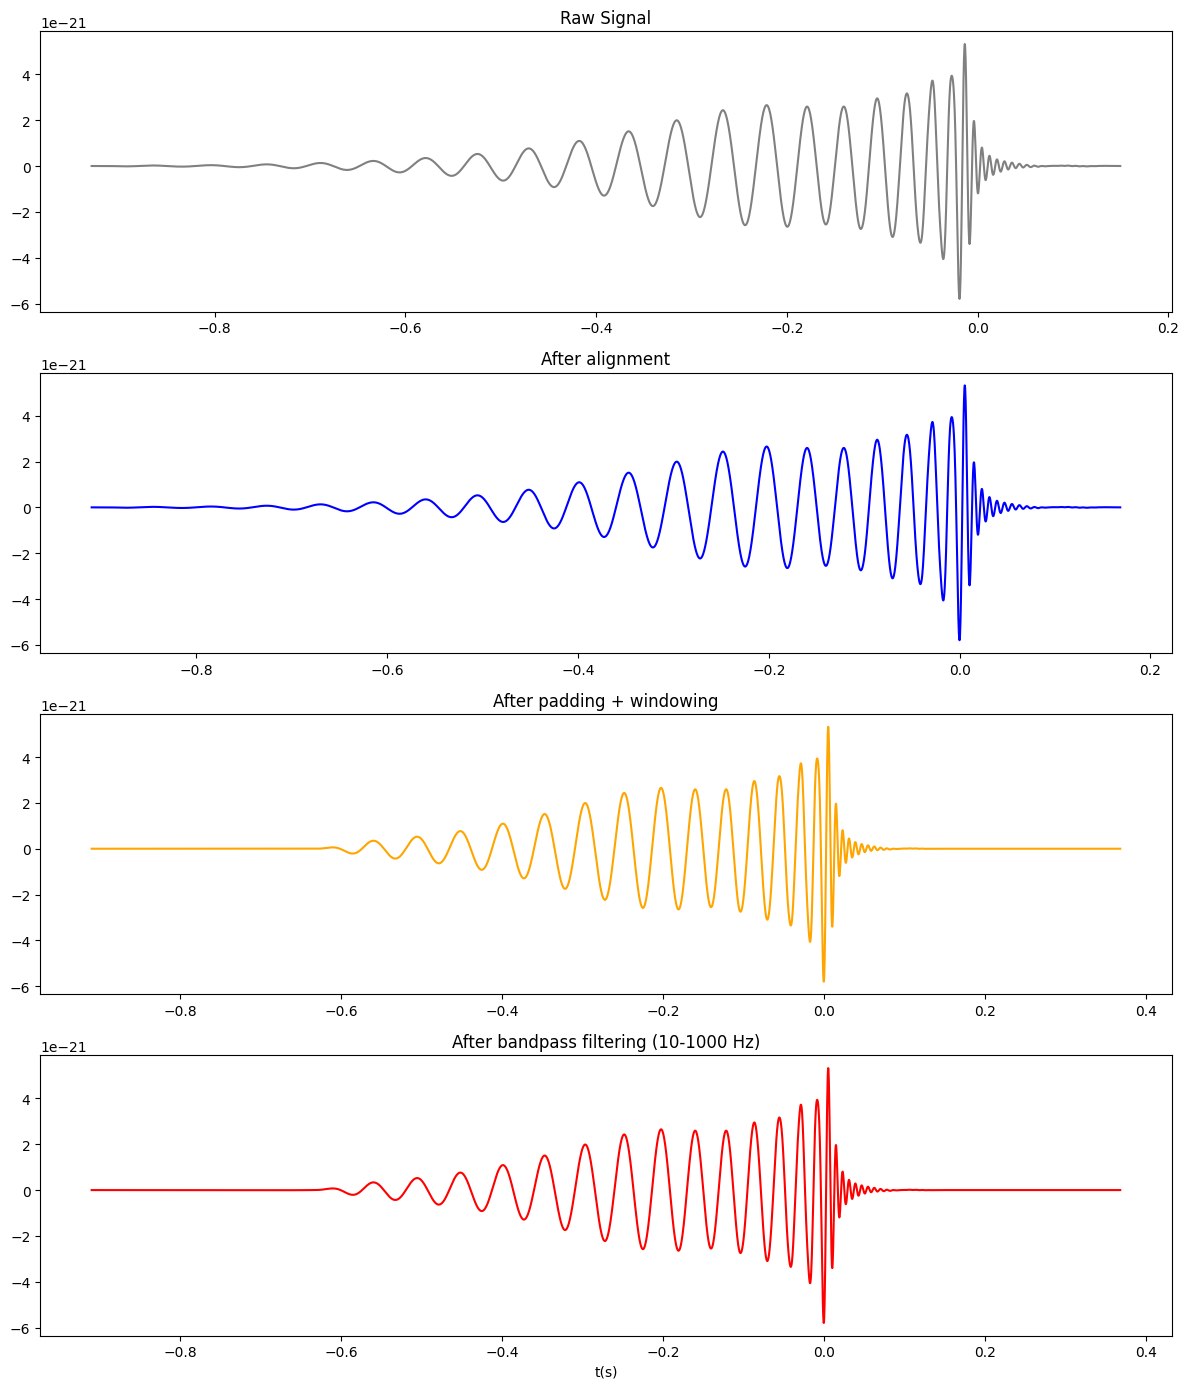

In [225]:
time_raw = hp.sample_times.numpy()

fig, axs = plt.subplots(4, 1, figsize=(12, 14))
axs[0].plot(time_raw, raw_signal, color='gray')
axs[0].set_title("Raw Signal")

axs[1].plot(aligned_time, aligned_signal, color='blue')
axs[1].set_title("After alignment")

axs[2].plot(padded_time, padded_signal, color='orange')
axs[2].set_title("After padding + windowing")

axs[3].plot(padded_time, filtered_signal, color='red')
axs[3].set_title("After bandpass filtering (10-1000 Hz)")

plt.xlabel('t(s)')
plt.tight_layout()
plt.show()

Now we can compute the memory signal and compare it with the raw signal in the frequency domain

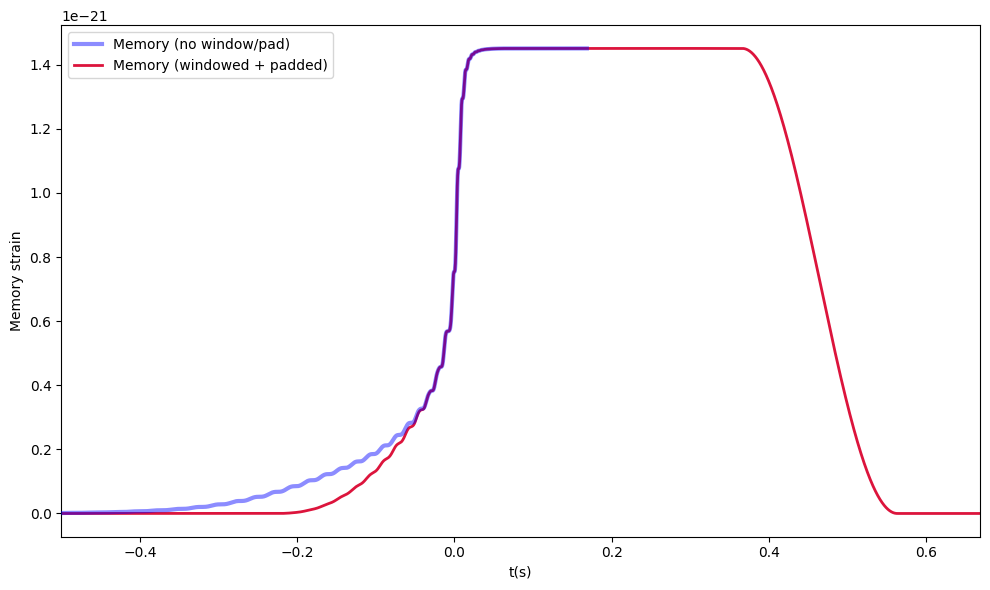

In [230]:
dt = 1.0/4096
distance = 100
mtot = 100  
hp, _ = get_td_waveform(approximant="SEOBNRv4_ROM_NRTidalv2",
                        mass1=mtot/2, mass2=mtot/2,
                        delta_t=dt, f_lower=20, distance=distance, inclination=np.pi/2)
time_raw  = hp.sample_times.numpy()
raw_signal = hp.numpy()
fs = int(1.0 / hp.delta_t)
s = 0.5  # seconds
aligned_time, aligned_signal = align_signal(raw_signal, time_raw)
padded_time, padded_signal = pad_signal(aligned_signal,aligned_time, s)

def compute_memory(signal, distance, dt):
    """Compute the GW memory"""
    h22 = signal / sYlm(-2, 2, 2, np.pi/2, np.pi/2)
    hdot = np.gradient(h22, dt)
    hdot_c = np.conjugate(hdot)
    integrand = hdot * hdot_c
    cumint = np.cumsum(integrand) * dt
    prefactor = (distance * 1e6 * PC_SI / C_SI) * (np.sin(np.pi/2))**2 * (17 + np.cos(np.pi/2)**2) / (192 * np.pi)
    hmem = prefactor * cumint
    return hmem

# Compute memory for both signals
hmem_centered = compute_memory(aligned_signal, distance, dt)
hmem_winpad = compute_memory(padded_signal , distance, dt)
hmem_winpad = apply_window(hmem_winpad, window_type='tukey', r = 0.5, alpha=0.5)
plt.figure(figsize=(10,6))
plt.plot(aligned_time, hmem_centered, label='Memory (no window/pad)', color='blue', lw = 3, zorder = 5, alpha=0.45)
plt.plot(padded_time, hmem_winpad, label='Memory (windowed + padded)', color='crimson', lw=2)
plt.xlabel('t(s)')
plt.ylabel('Memory strain')
plt.xlim(-0.5,np.max(padded_time))
plt.legend()
plt.tight_layout()
plt.show()

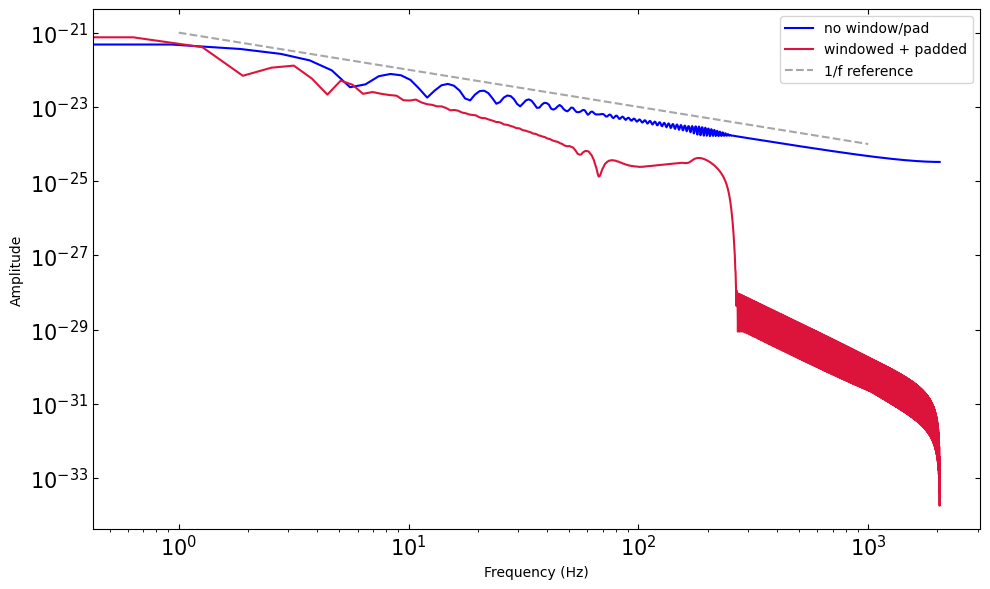

In [231]:
# FFT of the memory
freq_centered, fft_centered = fft_signal(aligned_time, hmem_centered)
freq_winpad, fft_winpad = fft_signal(padded_time, hmem_winpad)
# Also plot 1/f line for reference
f = np.logspace(0, 3, 100)
one_over_f = 1 / f

plt.figure(figsize=(10,6))
plt.plot(freq_centered, fft_centered, label='no window/pad', color='blue')
plt.plot(freq_winpad, fft_winpad, label='windowed + padded', color='crimson')
plt.plot(f, one_over_f*1e-21, label='1/f reference', color='grey', linestyle='--', alpha=0.7)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')
plt.yscale('log')
plt.tick_params(top=True, right=True, axis='both', which='major', labelsize=15, direction='in')
plt.legend()
plt.tight_layout()
plt.show()